In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string

from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from joblib import dump

In [24]:
fake_news = pd.read_csv('Fake.csv')
real_news = pd.read_csv('True.csv')

fake_news.head()
real_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


Exploratory Data Analysis

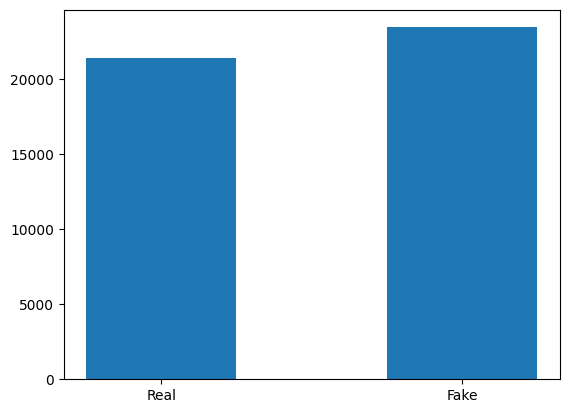

In [25]:
real_count = len(real_news)
fake_count = len(fake_news)
data_dict = {'Real':real_count, 'Fake':fake_count}
type = list(data_dict.keys())
count = list(data_dict.values())

plt.bar(type, count, width = 0.5)
plt.show()

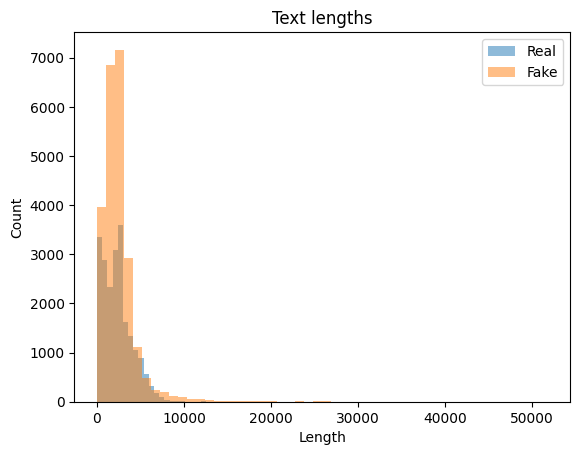

In [26]:
len_real = real_news['text'].apply(len)
len_fake = fake_news['text'].apply(len)

plt.hist(len_real, bins = 50, alpha = 0.5, label = 'Real')
plt.hist(len_fake, bins = 50, alpha = 0.5, label = 'Fake')
plt.title('Text lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

Length of texts are highly variable with some being very short (< 1000) and some being rather long (> 40000)

In [27]:
# Download stopwords and punkt
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kiahm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kiahm\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [28]:
def most_common_words(txt, n):
    all_words = []
    for text in txt:
        all_words.extend(nltk.word_tokenize(text.lower()))
    stop_words = set(nltk.corpus.stopwords.words('english'))
    words = [word for word in all_words if word.isalpha() and word not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(n)

real_most_common = most_common_words(real_news['text'], 10)
fake_most_common = most_common_words(fake_news['text'], 10)

print('Real:', real_most_common)
print('Fake:', fake_most_common)

Real: [('said', 99037), ('trump', 54249), ('would', 31526), ('reuters', 28412), ('president', 26397), ('state', 19728), ('government', 18288), ('new', 16784), ('house', 16519), ('states', 16515)]
Fake: [('trump', 74241), ('said', 31149), ('people', 26015), ('president', 25772), ('would', 23461), ('one', 22995), ('clinton', 18085), ('obama', 17920), ('like', 17660), ('donald', 17235)]


- Most common words in real and fake news centre around politics and trump.
- Fake news contain more references to clinton and has a greater use of words like 'like'

Text Preprocessing
- Lowercase text
- Remove punctuations and digits
- Remove stopwords
- Stemming/Lemmatizing text

In [29]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kiahm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def txt_preprocessor(text):
    # Lowercase text
    text = text.lower()

    # Remove punctuations and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))

    # Tokenize the text
    words = word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Stemming/Lemmatizing
    words = [stemmer.stem(word) for word in words]
    text = ' '.join(words)

    return text

real_news['text'] = real_news['text'].apply(txt_preprocessor)
fake_news['text'] = fake_news['text'].apply(txt_preprocessor)

Model Training

In [31]:
vectorizer = CountVectorizer()
real_X = vectorizer.fit_transform(real_news['text'])
fake_X = vectorizer.transform(fake_news['text'])

X = sp.vstack([real_X, fake_X])
y = np.concatenate([np.ones(real_X.shape[0]), np.zeros(fake_X.shape[0])])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Fit the model
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

C:\Users\kiahm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

Model Evaluation

In [33]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy: ', accuracy)
print('Precision: ', precision)
print('Recall: ', recall)
print('f1_score: ', f1)

Accuracy:  0.994988864142539
Precision:  0.9935498733010827
Recall:  0.9960739030023095
f1_score:  0.9948102871641102


The model achieved an accuracy and precision of 99%.

Saving the model

In [ ]:
dump(model, 'model.joblib')
dump(vectorizer, 'vectorizer.joblib')